<a href="https://colab.research.google.com/github/praksh87dakshina/sales-prediction/blob/main/Sales_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Sales Projection Project</b></h1>
<h2>Programmed By: Prakash87Dakshina <br>
February - March 2023 </h2>
In this project we will use previously captured data to predict sales at various store outlets for the benefit of the retail chain.

# Import Required Libraries & Clean the Data

## <h2>Importing Required Libraries</h2>



In [275]:
# Data Imports
import numpy as np
import pandas as pd

# Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt

# SKLearn Imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import set_config
set_config(display='diagram')

# Google Drive Import + Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <h2>Load and View the Data</h2>

In [231]:
filename = '/content/drive/My Drive/The Coding Dojo - Data Science/sales_predictions.csv'
df = pd.read_csv(filename, index_col='Item_Identifier')

df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,,,
FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


<p> Display the Rows/Columns and DataTypes</p>

In [232]:
df.shape #8523 Rows, 12 Columns

(8523, 11)

In [233]:
df.dtypes # Object, float64, and int64

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Inspect Duplicates

In [234]:
print(f"There are {df.duplicated().sum()} duplicates")

There are 0 duplicates


> No Duplicates

Identify Missing Values

In [235]:
print(df.isna().sum())

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


 > Item_Weight and Outlet_Size have missing data

Identify Inconsistent Values


In [236]:
print("--------")
print(df['Item_Fat_Content'].value_counts())
print("--------")
print(df['Item_Type'].value_counts())
print("--------")
print(df['Outlet_Size'].value_counts())
print("--------")
print(df['Outlet_Location_Type'].value_counts())
print("--------")
print(df['Outlet_Type'].value_counts())
print("--------")

--------
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
--------
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
--------
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
--------
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
--------
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64
--------


> Item_Fat_Content has inconsistencies (LF, reg, low fat)

View the numerical colmns summary to better understand the data

In [237]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## <h2>Clean the Data</h2>

### <p> NaN Values </p>

For Item_Weight we will use the average weight of all of the items so we don't skew the data values. It is a significant part of the data so we don't want to drop it. <br>
For the missing outlet_sizes we will replace the NaN values with Unknown since there are 3 outlets, OUT013, OUT017, and OUT045 and we have no identifiers as to which each belong. It is a large portion of the data so we will avoid dropping it.

In [238]:
average_weight = df['Item_Weight'].mean()
df.loc[:, 'Item_Weight'].fillna(average_weight, inplace = True)
df.loc[:, 'Outlet_Size'].fillna("Unknown", inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, FDA15 to DRG01
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 799.0+ KB


Let's confirm there are no other missing values

In [239]:
print(df.isna().sum())

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


### <p> Inconsistent Values </p>

In [240]:
df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace = True)
df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace = True)
df['Item_Fat_Content'].replace('reg', 'Regular', inplace = True)

# Exploratory Data Analysis

## <h2> Amount of Items compared to Item MRP </h2>

<p> Let's set the standard to seaborn for our graph </p>

In [241]:
plt.style.use('seaborn')

<p> Histogram </p>

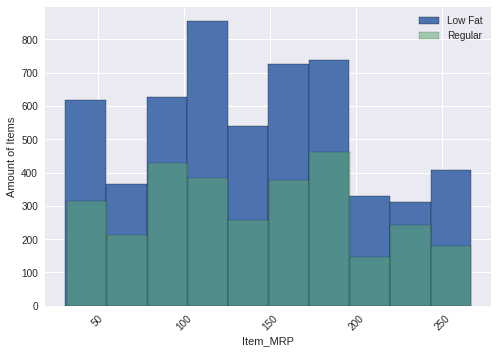

In [242]:
df.loc[df['Item_Fat_Content'] == "Low Fat", 'Item_MRP'].hist(edgecolor='black', label = "Low Fat")
df.loc[df['Item_Fat_Content'] == "Regular", 'Item_MRP'].hist(edgecolor='black', label = "Regular", alpha = 0.5)
plt.legend()
plt.xlabel("Item_MRP")
plt.ylabel("Amount of Items")
plt.xticks(rotation = 45)
plt.ticklabel_format(useOffset=False, style='plain')

Based on the graph we can see that overall in the stores low fat items come with a higher cost than regular items. This data can be useful, especially after analyzing the sales of low fat and regular items, in determining where/how items are stocked and sold.

## Correlation of Each Property

<p> Heatmap </p>

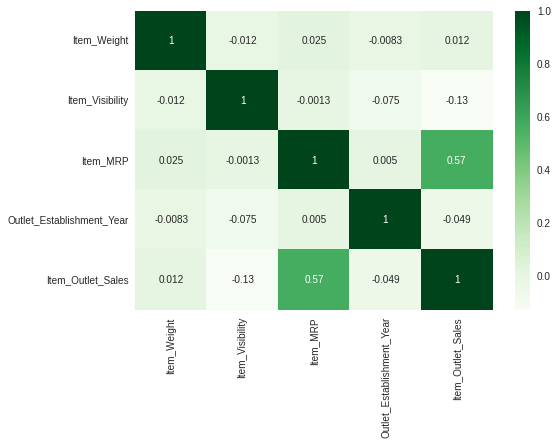

In [243]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)

We can see using our heatmap that the Outlet Sales and Item MRP have a moderate correlation. This makes sense since, generally, the higher priced the item is the higher we would expect the sum of the sales of the item to be.

## Price of the Item Boxplot

<p> View the boxplot of average price per item </p>

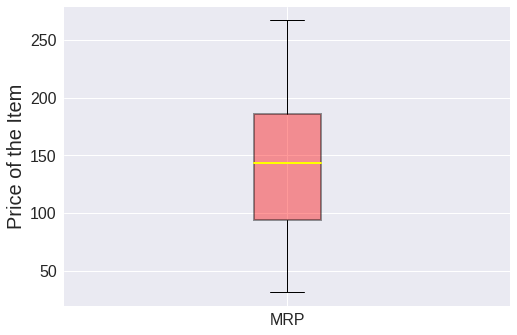

In [244]:
mrp = df['Item_MRP']
sales = df['Item_Outlet_Sales']
fig, axes = plt.subplots()
boxplots = axes.boxplot([mrp],
           labels=['MRP'],
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );
boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('red')
plt.ylabel('Price of the Item', fontsize = 20);
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);

Analyzing the average price per item, we can see that items typically don't exceed the $250 mark. Knowing the price of our items and how they affect our sales are important to be able to accurately project sales later on.

## Barplot for Categorical Sales

Look for any significant difference between item category and their sales amount

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

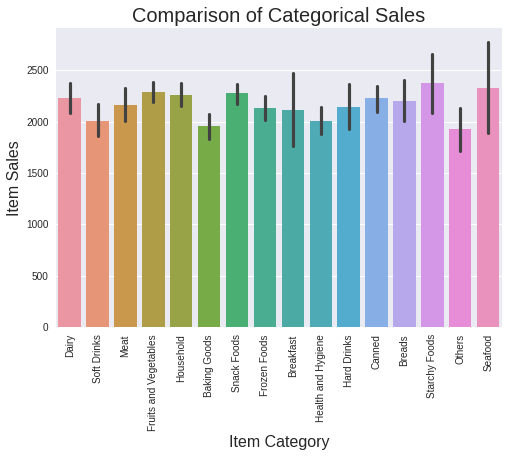

In [245]:
sns.barplot(data = df, x = "Item_Type", y = 'Item_Outlet_Sales')
plt.ylabel("Item Sales", fontsize = 16)
plt.xlabel("Item Category", fontsize = 16)
plt.title("Comparison of Categorical Sales", fontsize = 20)
plt.xticks(rotation = 90)

There isn't any category that significantly outperforms any other.

## Item Price compared to Item Sales

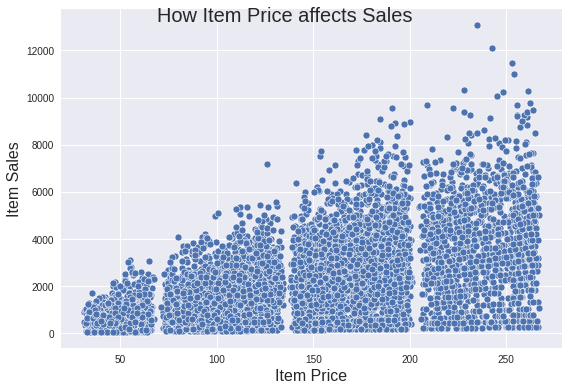

In [246]:
fig, axes = plt.subplots()
sns.scatterplot(data = df, y = "Item_Outlet_Sales", x = "Item_MRP")
axes.set_xlabel("Item Price", fontsize = 16)
axes.set_ylabel("Item Sales", fontsize = 16)
fig.suptitle("How Item Price affects Sales", fontsize = 20)
plt.tight_layout()

Typically, the higher an items price is the more revenue in sales it brings in.

# Preprocessing for Machine Learning


## <h2> Identify Target and Features </h2>

Data Validation Split

In [247]:
X = df.drop('Item_Outlet_Sales', axis = 1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## <h2> Instantiate Selectors </h2>

In [248]:
# Create our selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

cat_selector(X_train)
num_selector(X_train)

# Create Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# Create Scaler & One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = StandardScaler()

## <h2> Instantiate Pipelines </h2>

In [249]:
# Create Pipelines
categorical_pipeline = make_pipeline(freq_imputer, ohe)
numeric_pipeline = make_pipeline(mean_imputer, scaler)

# Create Tuples for Column Transformer
category_tuple = (categorical_pipeline, cat_selector)
number_tuple = (numeric_pipeline, num_selector)

## <h2> Instantiate Column Transformer, Fit, and Transform

In [250]:
# Create the Column Transformer
preprocessor = make_column_transformer(category_tuple, number_tuple)

# Fit on Training Set
preprocessor.fit(X_train)

# Transform Data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## <h2> Look at Pre-Processed Data </h2>

Inspecting for missing values

In [251]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')

0 missing values in training data
0 missing values in testing data


# <h1> Processing Data </h1>

## <h2> Linear Regression Model<h2>

Instatiate the model

In [254]:
lr = LinearRegression()
lr.fit(X_train_processed, y_train);

Predict the data

In [258]:
train_preds = lr.predict(X_train_processed)
test_preds = lr.predict(X_test_processed)

Evaluate the performance

In [259]:
lr_train_score = lr.score(X_train_processed, y_train)
lr_test_score = lr.score(X_test_processed, y_test)
print(f"Linear Regression Train R^2 Score: {lr_train_score}")
print(f"Linear Regression Test R^2 Score: {lr_test_score}")

Linear Regression Train R^2 Score: 0.5594470758968336
Linear Regression Test R^2 Score: 0.5668261155895282


Based on the R^2 score, our performance is quite unsatisfactory. Ideally another model will be more suited.

In [262]:
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"Linear Regression Train RMSE Score: {rmse_train}")
print(f"Linear Regression Test RMSE Score: {rmse_test}")

Linear Regression Train RMSE Score: 1141.8392462965055
Linear Regression Test RMSE Score: 1093.2140269679476


According to the RMSE Score, our model is about $1093 off (on average) for each prediction. This is not the results we were hoping for so we will move onto a regression tree model.

## <h2> Regression Tree Model </h2>


Instatiate the model

In [279]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

Evaluate the performance

In [284]:
dec_tree_train_score = dec_tree.score(X_train_processed, y_train)
dec_tree_test_score = dec_tree.score(X_test_processed, y_test)
print(f"Decision Tree R^2 Train Score: {dec_tree_train_score}")
print(f"Decision Tree R^2 Test Score: {dec_tree_test_score}")

Decision Tree R^2 Train Score: 1.0
Decision Tree R^2 Test Score: 0.20811562911898385


We can see that the model is overfit from the difference in Training and Testing scores. Before we find the RMSE, let's fine tune the model.

### <p> Fine Tune Regression Tree </p>

<p> First let's view parameters to see what the defaults are. </p>

In [287]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [288]:
dec_tree.get_depth()

40

It is using a depth of 40, which is most likely not the most ideal. We are able to loop through other possible depths to search for better results. Let's check each possible depth between 1 and 45.

In [291]:
max_depth_range = list(range(1, 45))
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train_processed, y_train)
    score = dec_tree.score(X_test_processed, y_test)
    r2.append(score)

Let's view the different depths on a graph, to easily understand them.

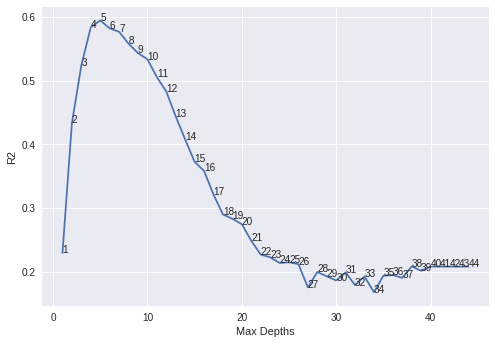

In [293]:
plt.plot(max_depth_range, r2)
plt.xlabel('Max Depths')
plt.ylabel('R2');
for a,b in zip(max_depth_range, r2): # Credit https://stackoverflow.com/a/36029361 Marvin W
    plt.text(a, b, str(a))
plt.show()

From this graph we can see that a depth of 5 is ideal for this model. Let's create another model with these params.

In [296]:
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_processed, y_train);

View our new R^2 Scores

In [297]:
dec_tree_5_train_score = dec_tree_5.score(X_train_processed, y_train)
dec_tree_5_test_score = dec_tree_5.score(X_test_processed, y_test)
print(f"Decision Tree R^2 Train Score: {dec_tree_5_train_score}")
print(f"Decision Tree R^2 Test Score: {dec_tree_5_test_score}")

Decision Tree R^2 Train Score: 0.6039397477322956
Decision Tree R^2 Test Score: 0.5947099753159973


This model performs much better than the overfit data from earlier. It also outperforms our Linear Regression model.

Create predictions based on the model

In [299]:
dec_train_5_preds = dec_tree_5.predict(X_train_processed)
dec_test_5_preds = dec_tree_5.predict(X_test_processed)

In [301]:
dec_tree_5_train_rmse = np.sqrt(mean_squared_error(y_train, dec_train_5_preds))
dec_tree_5_test_rmse = np.sqrt(mean_squared_error(y_test, dec_test_5_preds))
print(f"Decision Tree Train RMSE Score: {dec_tree_5_train_rmse}")
print(f"Decision Tree Test RMSE Score: {dec_tree_5_test_rmse}")

Decision Tree Train RMSE Score: 1082.6461900869947
Decision Tree Test RMSE Score: 1057.4431299496732


Our RMSE shows us that we are about 40 points closer on our test data than with the linear regression model.

# <h1> Implementation </h1>

<p> After using both Linear Regression and a Decision Tree Regression model, it is recommended you use a fine-tuned Decision Tree for implementation. The Decision Tree Regresion was more accurate both in R2 score as well as RMSE than a Linear Regression Model, and once fine-tuned, is more efficient. Overall, if the time and resources permit, I'd recommend exploring other types of models to see if you can create a more accurate prediction since even our Decision Tree is only 59.4% accurate in practice.</p>
